# Traffic Sign Recognition
**In this project i used tensorflow for training a model used in classifing and recognising traffic signs.**

**This project from The Sparks Foundation | GRIP internship**

 * Author: Hatem Mohamed Ahmed Rashed
 * https://www.linkedin.com/in/hatem-mohamed-6175b0244/

Here is the table of content:
* Defining the required libraries and loading the german traffic sgin recognition dataset.
* Splitting Train, Test and Validation Data and pre-processing the data for each model.
* Handling the classes imbalance.
* Defining the CNN model and the pre-trained model.
* Training the model and calculating its accuracy.
* Evaluating the model on test data.
* Visualizing the CNN Model Layers.

# Downloading the dataset

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tommy011","key":"2a34fc4484bbd31062ee39c402c8b042"}'}

In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 610M/612M [00:28<00:00, 22.7MB/s]
100% 612M/612M [00:28<00:00, 22.6MB/s]


In [4]:
!mkdir Dataset
!unzip -q /content/gtsrb-german-traffic-sign.zip -d /content/Dataset
!rm /content/gtsrb-german-traffic-sign.zip

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Python libraries

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import tensorflow_hub as hub
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
import keras

from keras import backend as K
from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.utils import to_categorical

from sklearn.utils import shuffle

# **Data Exploration**

In [6]:
#meta dataset represents clear images of the signs
meta_dataset = pd.read_csv('/content/Dataset/Meta.csv')
meta_dataset.head(10)

Path  ClassId  ShapeId  ColorId SignId
0  Meta/27.png       27        0        0   1.32
1   Meta/0.png        0        1        0   3.29
2   Meta/1.png        1        1        0   3.29
3  Meta/10.png       10        1        0   3.27
4  Meta/11.png       11        0        0   1.22
5  Meta/12.png       12        2        2    2.3
6  Meta/13.png       13        4        0    2.1
7  Meta/14.png       14        3        0    2.2
8  Meta/15.png       15        1        0    3.1
9  Meta/16.png       16        1        0    3.3

In [7]:
#classes labels represented in dictionary
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons'
          }

# Preprocess the dataframe

In [8]:
def prepare_inputs(dataset):
    dataset_cp           = dataset.copy()
    files_path           = '/content/Dataset/'                                 # the default path after downloading the dataset in colab notebook
    dataset_cp['Path']   = files_path + dataset_cp['Path']                     # modifing the paths of the images to the actual path

    dataset_cp['Target'] = ''                                                  # adding a 'target' column will contain the categorical names of the signs classes
    for index in range(len(dataset_cp)):
        dataset_cp.loc[index,'Target'] = classes[dataset_cp['ClassId'][index]]
    return dataset_cp

In [9]:
meta_dataset_v2 = prepare_inputs(meta_dataset)
meta_dataset_v2.head()

Path  ClassId  ShapeId  ColorId SignId  \
0  /content/Dataset/Meta/27.png       27        0        0   1.32   
1   /content/Dataset/Meta/0.png        0        1        0   3.29   
2   /content/Dataset/Meta/1.png        1        1        0   3.29   
3  /content/Dataset/Meta/10.png       10        1        0   3.27   
4  /content/Dataset/Meta/11.png       11        0        0   1.22   

                         Target  
0                   Pedestrians  
1          Speed limit (20km/h)  
2          Speed limit (30km/h)  
3  No passing veh over 3.5 tons  
4  Right-of-way at intersection

# Visualizing meta dataset images

In [10]:
def image_viewer(dataset, index, ax):
    image_path =  dataset['Path'][index]
    image      =  Image.open(image_path)
    ax.imshow(image)
def plot_some_images(dataset, title):
    fig, axs = plt.subplots(nrows = 4,ncols = 10,figsize=(20,8))
    for ind, ax in enumerate(axs.flat):
            index = random.randrange(len(dataset))                  # choosing a random image from the dataset
            image_viewer(dataset, index, ax)
            ax.set_title(dataset['Target'][index], fontsize = 8)
            ax.axis('off')
            fig.suptitle(title, fontsize = 15)
    plt.show()

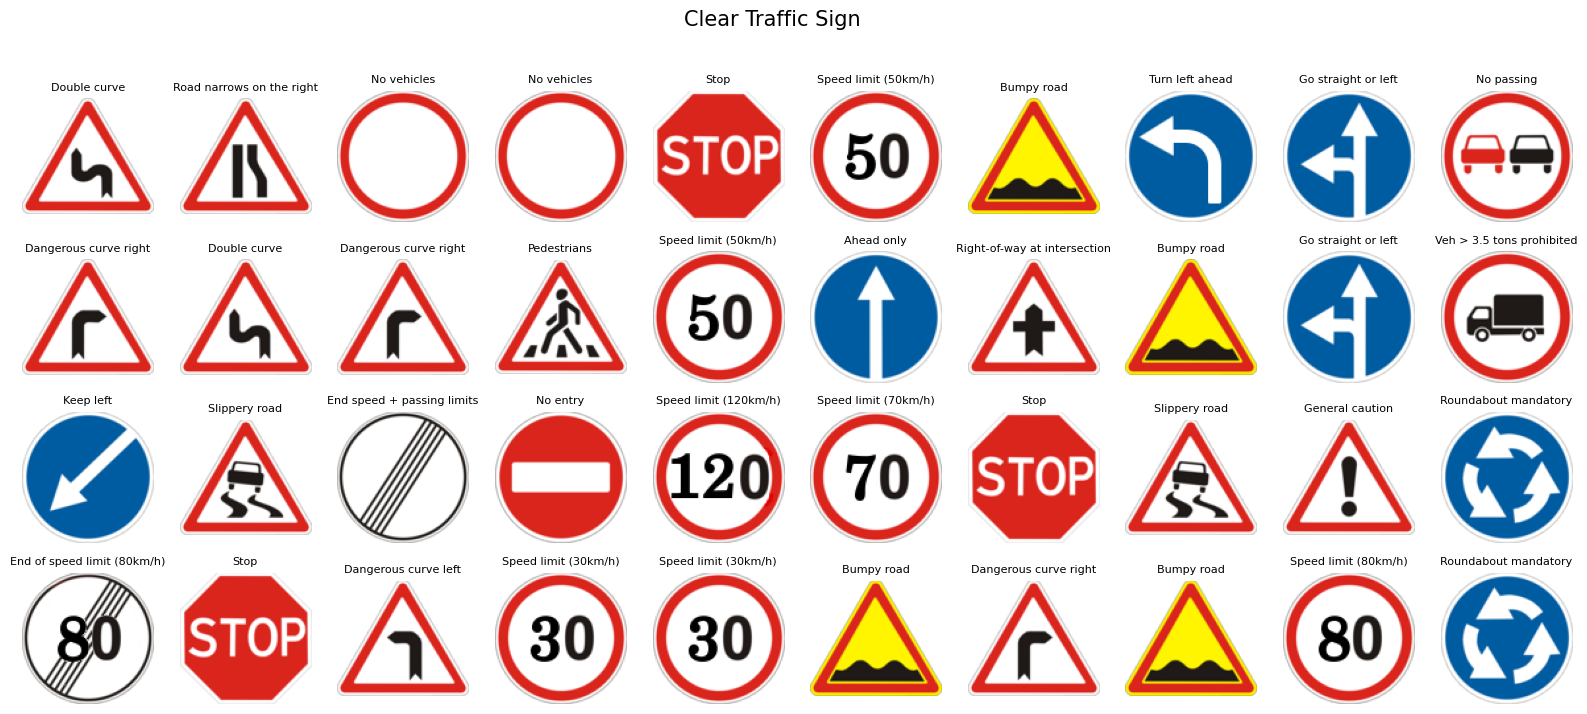

In [11]:
plot_some_images(meta_dataset_v2, 'Clear Traffic Sign')

# Preprocessing the images

for the pretrained model i used its preprocessing function

while for the CNN model i just normalized the pixel values 

In [12]:
def intialize_imagegenerator(transfermodel = 0,
                              useaugmentations = 0):
      if transfermodel:
        preprocessingfunction = tf.keras.applications.efficientnet.preprocess_input
        resc = None
      else:
        preprocessingfunction =None
        resc = 1/255.0

      test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
              rescale = resc,
              preprocessing_function=preprocessingfunction)

      if useaugmentations :
          train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
              rescale = resc,
              preprocessing_function=preprocessingfunction,
              rotation_range     = 25,
              width_shift_range  = 0.1,
              height_shift_range = 0.1,
              shear_range        = 0.1,
              horizontal_flip    = True,
              vertical_flip      = True)
      else:
          train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
              rescale = resc,
              preprocessing_function= preprocessingfunction)
      return train_generator, test_generator

In [13]:
def generate_images(dataset ,
                    y_label_col,
                    x_col ,
                    size ,
                    batch_size,
                    generator,
                    use_augmentations,
                    transfer_model):
    train_generator, test_generator = intialize_imagegenerator(transfer_model, use_augmentations)

    if generator == 0:
            generator =    train_generator

    else :
            generator =    test_generator

    images = generator.flow_from_dataframe(
              dataframe    =  dataset,
              x_col        =   x_col,
              y_col        =   y_label_col,
              target_size  =  (size, size),
              color_mode   =  'rgb',
              class_mode   =  'categorical',
              batch_size   =   batch_size,
              shuffle      =   True,
              random_seed = 42)
    labels = shuffle(dataset[y_label_col].copy(), random_state=1)
    return images, labels

In [14]:
trans_meta_train_images, trans_meta_train_label = generate_images(dataset = meta_dataset_v2,
                                                                  y_label_col = 'Target',
                                                                  x_col = 'Path',
                                                                  size = 64,
                                                                  batch_size = 43,
                                                                  generator = 0 ,
                                                                  use_augmentations = 1,
                                                                  transfer_model = 1)

Found 43 validated image filenames belonging to 43 classes.


In [15]:
cnn_meta_train_images, cnn_meta_train_label = generate_images(dataset = meta_dataset_v2,
                                                                  y_label_col = 'Target',
                                                                  x_col = 'Path',
                                                                  size = 64,
                                                                  batch_size = 43,
                                                                  generator = 0 ,
                                                                  use_augmentations = 1,
                                                                  transfer_model = 0)

Found 43 validated image filenames belonging to 43 classes.


# Defining The Models

In [16]:
def TransL_Model_init(trans_model     = None,
                     input_image_size = 64,
                     dence1           = 1080,
                     dence2           = 1080,
                     regularizer      = 0.0,
                     drop             = 0.2,
                     drop_conv        = 0.2):

      trans_arc = trans_model(weights = "imagenet", include_top = False,
                        input_shape=(input_image_size, input_image_size,3), pooling='max')
      for l in trans_arc.layers:
        l.trainable = False
      inputs = trans_arc.input
      flatten = trans_arc.output
      x = tf.keras.layers.Flatten()(flatten)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Dropout(drop_conv)(x)

      x = tf.keras.layers.Dense(dence1, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.L2(regularizer))(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Dropout(drop)(x)
      x = tf.keras.layers.Dense(dence2, activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(regularizer))(x)
      x =tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.Dropout(drop)(x)

      outputs = tf.keras.layers.Dense(43, activation='softmax')(x)

      model = tf.keras.Model(inputs=inputs, outputs=outputs)


      return model

In [17]:
def CNN_Model_init(
            input_image_size = 64  ,
               dence         = 1080,
               regularizer   = 0.05,
               drop_conv     = 0.2 ,
               drop_dense    = 0.3):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(input_image_size,input_image_size,3)),
    tf.keras.layers.BatchNormalization(axis=-1),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Dropout(rate=drop_conv),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(axis=-1),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Dropout(rate=drop_conv),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dence, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(regularizer)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=drop_dense),

    tf.keras.layers.Dense(43, activation='softmax')])
    return model

In [18]:
# the implmentation of the transfer learning model on the meta dataset
trans_model= tf.keras.applications.EfficientNetB0
meta_trans_model = TransL_Model_init(trans_model,input_image_size = 64,
                                     dence1=256,
                                     dence2=256,
                                     regularizer=0.0,
                                     drop= 0.0)
meta_trans_model.summary()

16705208/16705208 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 64, 64, 3)            0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 64, 64, 3)            7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     

In [19]:
# the implmentation of the cnn model on the meta dataset
meta_cnn_model = CNN_Model_init(
                input_image_size = 64  ,
                dence         = 1080,
                regularizer   = 0.02,
                drop_conv     = 0.0 ,
                drop_dense    = 0.0)
meta_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        2432      
                                                                 
 batch_normalization_3 (Bat  (None, 60, 60, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 32)        0         
 D)                                                              
                                                                 
 batch_normalization_4 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                        

### Defining the needed metrices during training and evaluating

In [20]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Compiling the models

In [21]:
def Model_compile_param(model = None,
                        initial_learning_rate      = 1e-3,
                        learning_rate_decay_steps  =300,
                        learning_rate_decay_rate   =0.9,
                        Adam_beta_1                =0.9,
                        Adam_beta_2                =0.999,):

    loss = [tf.keras.losses.CategoricalCrossentropy()]

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps  =learning_rate_decay_steps,
        decay_rate   =learning_rate_decay_rate,
        staircase    =True)

    optimizer = tf.keras.optimizers.Adam(
        learning_rate= lr_schedule,
        beta_1       =Adam_beta_1,
        beta_2       =Adam_beta_2,
        epsilon      =1e-07,
    )
    metrics= ['accuracy', f1_m ]

    model.compile( optimizer=optimizer,
                loss= loss,
                metrics=metrics)
    return model ,lr_schedule

In [22]:
meta_trans_model ,lr_schedule= Model_compile_param(model = meta_trans_model,
                                                  initial_learning_rate      = 5e-3,
                                                  learning_rate_decay_steps  = 1,
                                                  learning_rate_decay_rate   =0.9,
                                                  Adam_beta_1                =0.9,
                                                  Adam_beta_2                =0.999,)

# Trainig the model on meta dataset

In [23]:
history = meta_trans_model.fit(
      trans_meta_train_images,
      verbose = True,
      epochs=100,
            callbacks=[
        tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

Epoch 1/100
1/1 [==============================] - 20s 20s/step - loss: 4.6586 - accuracy: 0.0000e+00 - f1_m: 0.0000e+00 - lr: 0.0050
Epoch 2/100
1/1 [==============================] - 0s 109ms/step - loss: 2.6641 - accuracy: 0.3256 - f1_m: 0.2041 - lr: 0.0045
Epoch 3/100
1/1 [==============================] - 0s 107ms/step - loss: 2.0158 - accuracy: 0.4884 - f1_m: 0.3158 - lr: 0.0040
Epoch 4/100
1/1 [==============================] - 0s 120ms/step - loss: 1.4013 - accuracy: 0.5814 - f1_m: 0.4333 - lr: 0.0036
Epoch 5/100
1/1 [==============================] - 0s 107ms/step - loss: 1.5734 - accuracy: 0.6279 - f1_m: 0.5833 - lr: 0.0033
Epoch 6/100
1/1 [==============================] - 0s 108ms/step - loss: 1.2498 - accuracy: 0.5581 - f1_m: 0.5484 - lr: 0.0030
Epoch 7/100
1/1 [==============================] - 0s 105ms/step - loss: 1.0504 - accuracy: 0.6512 - f1_m: 0.6250 - lr: 0.0027
Epoch 8/100
1/1 [==============================] - 0s 107ms/step - loss: 1.0757 - accuracy: 0.6512 - f1_

In [24]:
meta_cnn_model ,lr_schedule= Model_compile_param(model = meta_cnn_model ,
                                                 initial_learning_rate      = 5e-3,
                                                  learning_rate_decay_steps  = 1,
                                                  learning_rate_decay_rate   =0.9,
                                                  Adam_beta_1                =0.9,
                                                  Adam_beta_2                =0.999,)

In [25]:
history = meta_cnn_model.fit(
      cnn_meta_train_images,
      verbose = True,
      epochs=100,
            callbacks=[
        tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

Epoch 1/100
1/1 [==============================] - 9s 9s/step - loss: 43.3440 - accuracy: 0.0233 - f1_m: 0.0000e+00 - lr: 0.0050
Epoch 2/100
1/1 [==============================] - 0s 111ms/step - loss: 46.9956 - accuracy: 0.2326 - f1_m: 0.2338 - lr: 0.0045
Epoch 3/100
1/1 [==============================] - 0s 103ms/step - loss: 50.6726 - accuracy: 0.1395 - f1_m: 0.1471 - lr: 0.0040
Epoch 4/100
1/1 [==============================] - 0s 110ms/step - loss: 52.4304 - accuracy: 0.2558 - f1_m: 0.2254 - lr: 0.0036
Epoch 5/100
1/1 [==============================] - 0s 111ms/step - loss: 53.5350 - accuracy: 0.2326 - f1_m: 0.2740 - lr: 0.0033
Epoch 6/100
1/1 [==============================] - 0s 118ms/step - loss: 53.4695 - accuracy: 0.3488 - f1_m: 0.3768 - lr: 0.0030
Epoch 7/100
1/1 [==============================] - 0s 112ms/step - loss: 53.4190 - accuracy: 0.3953 - f1_m: 0.4286 - lr: 0.0027
Epoch 8/100
1/1 [==============================] - 0s 133ms/step - loss: 53.1103 - accuracy: 0.3488 - f

In [26]:
sklearn.metrics.accuracy_score(np.argmax(meta_trans_model.predict(trans_meta_train_images), axis=1), trans_meta_train_images.labels)

1/1 [==============================] - 3s 3s/step


0.046511627906976744

In [27]:
sklearn.metrics.accuracy_score(np.argmax(meta_cnn_model.predict(cnn_meta_train_images), axis=1), cnn_meta_train_images.labels)

1/1 [==============================] - 0s 352ms/step


0.023255813953488372

bad model since couldn't learn much

# Exploring Train and Test datasets

In [28]:
train_dataset = pd.read_csv('/content/Dataset/Train.csv')
train_dataset.head(5)

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png

In [29]:
test_dataset = pd.read_csv('/content/Dataset/Test.csv')
test_dataset.head(5)

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png

In [30]:
train_dataset   = prepare_inputs(train_dataset)
test_dataset    = prepare_inputs(test_dataset)

In [31]:
train_dataset.head()

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                                              Path                 Target  
0  /content/Dataset/Train/20/00020_00000_00000.png  Dangerous curve right  
1  /content/Dataset/Train/20/00020_00000_00001.png  Dangerous curve right  
2  /content/Dataset/Train/20/00020_00000_00002.png  Dangerous curve right  
3  /content/Dataset/Train/20/00020_00000_00003.png  Dangerous curve right  
4  /content/Dataset/Train/20/00020_00000_00004.png  Dangerous curve right

In [32]:
test_dataset.head()

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     53      54       6       5      48      49       16   
1     42      45       5       5      36      40        1   
2     48      52       6       6      43      47       38   
3     27      29       5       5      22      24       33   
4     60      57       5       5      55      52       11   

                              Path                        Target  
0  /content/Dataset/Test/00000.png     Veh > 3.5 tons prohibited  
1  /content/Dataset/Test/00001.png          Speed limit (30km/h)  
2  /content/Dataset/Test/00002.png                    Keep right  
3  /content/Dataset/Test/00003.png              Turn right ahead  
4  /content/Dataset/Test/00004.png  Right-of-way at intersection

# Visualizing Train and Test Images

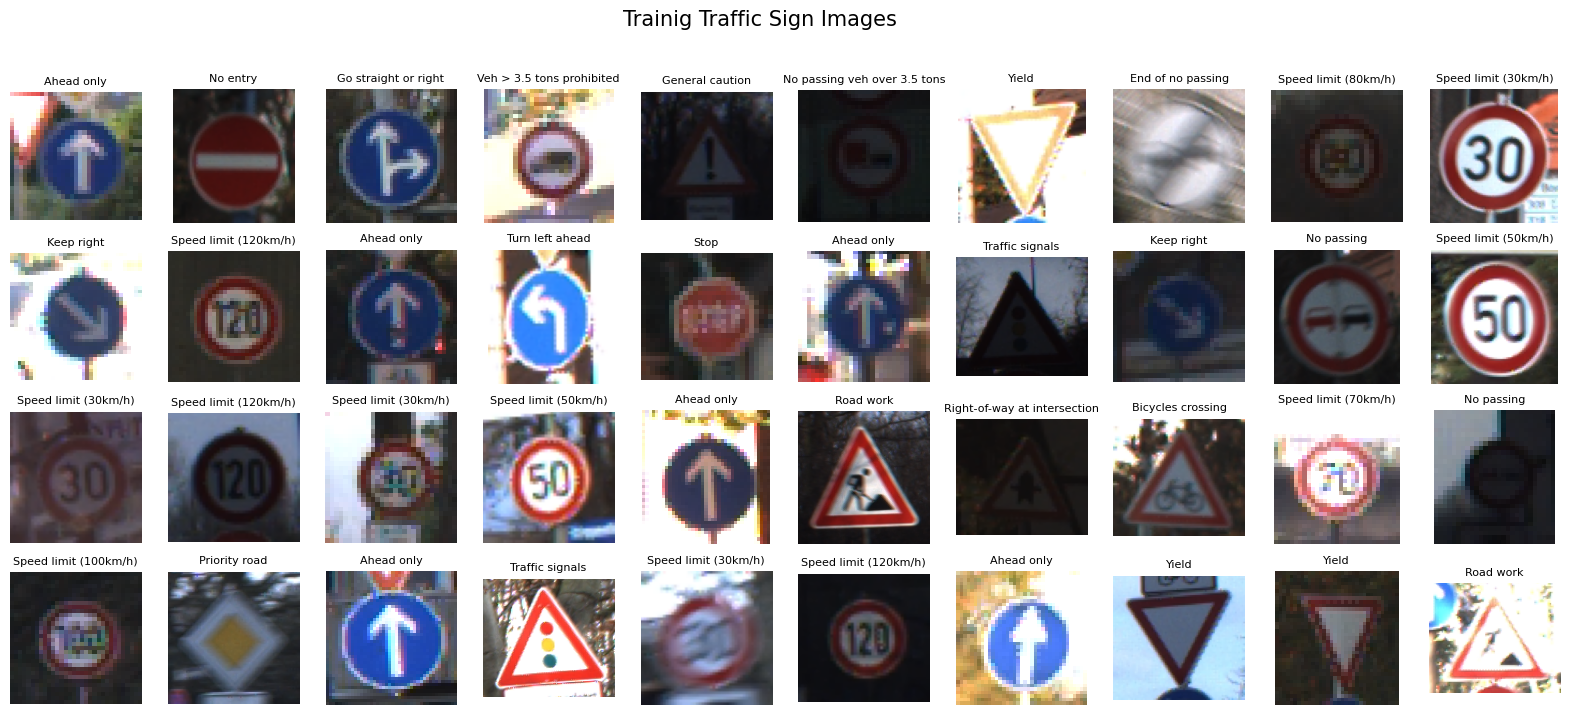

In [33]:
plot_some_images(train_dataset, 'Trainig Traffic Sign Images')

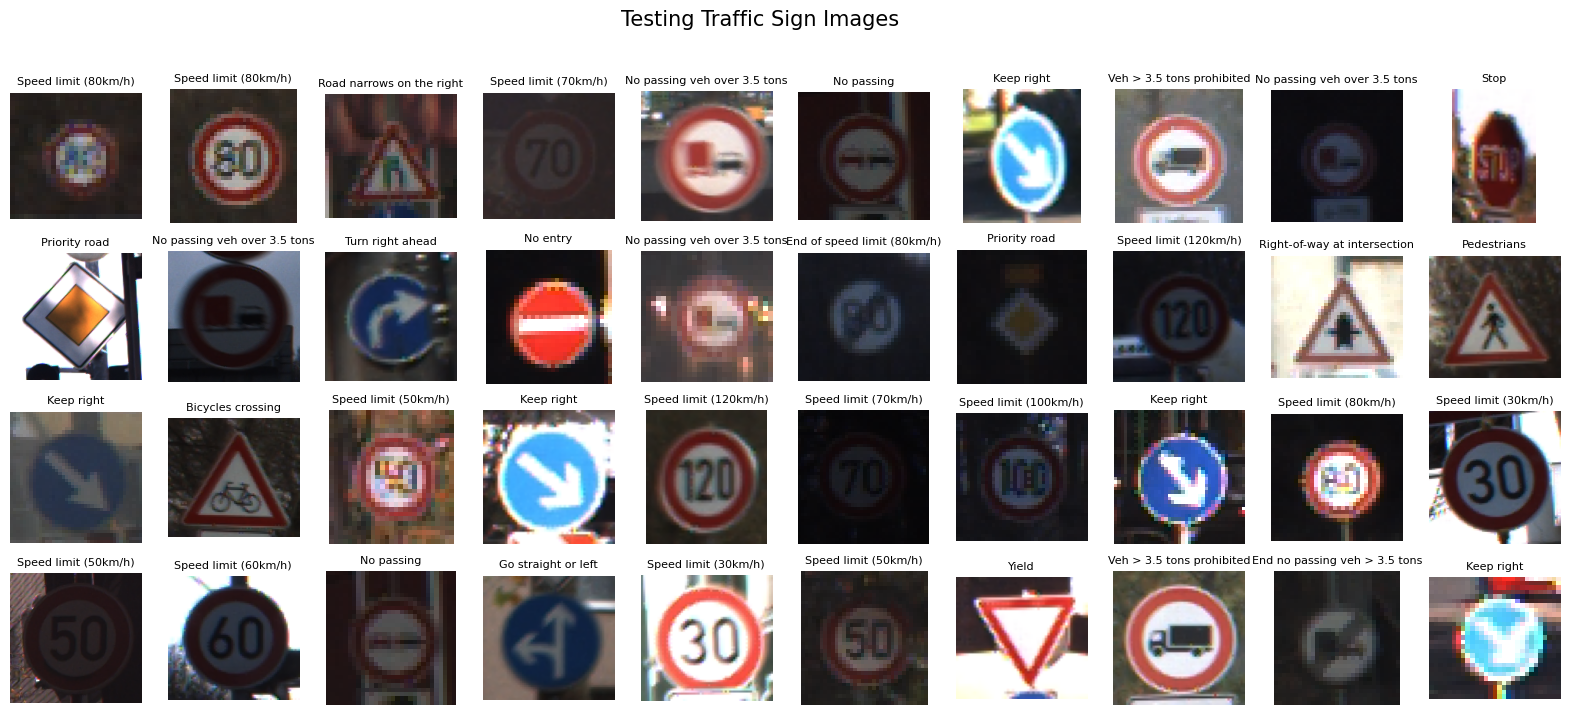

In [34]:
plot_some_images(test_dataset, 'Testing Traffic Sign Images')

# Plotting the data distribution

In [36]:
def get_class_counts(dataset):
    class_counts = {}
    for class_id in dataset['Target'].unique():
        counts                 = len(dataset[dataset['Target'] == class_id])
        class_counts[class_id] = counts
    return class_counts

In [37]:
train_class_counts = get_class_counts(train_dataset)
test_class_counts  = get_class_counts(test_dataset)

In [38]:
def plot_class_counts(class_counts, title):
    plt.figure(figsize=(20,5))
    class_counts_cp =  dict(sorted(class_counts.items(), key=lambda x:x[1]))
    names = list(class_counts_cp.keys())
    values  = list(class_counts_cp.values())
    plt.bar(range(len(class_counts_cp)), values, tick_label=names)

    plt.xlabel('Target', fontsize= 10)
    plt.ylabel('Counts', fontsize= 10)
    plt.title(title +'-dataset class counts', fontsize= 15)
    plt.xticks(rotation = 90)
    plt.show()

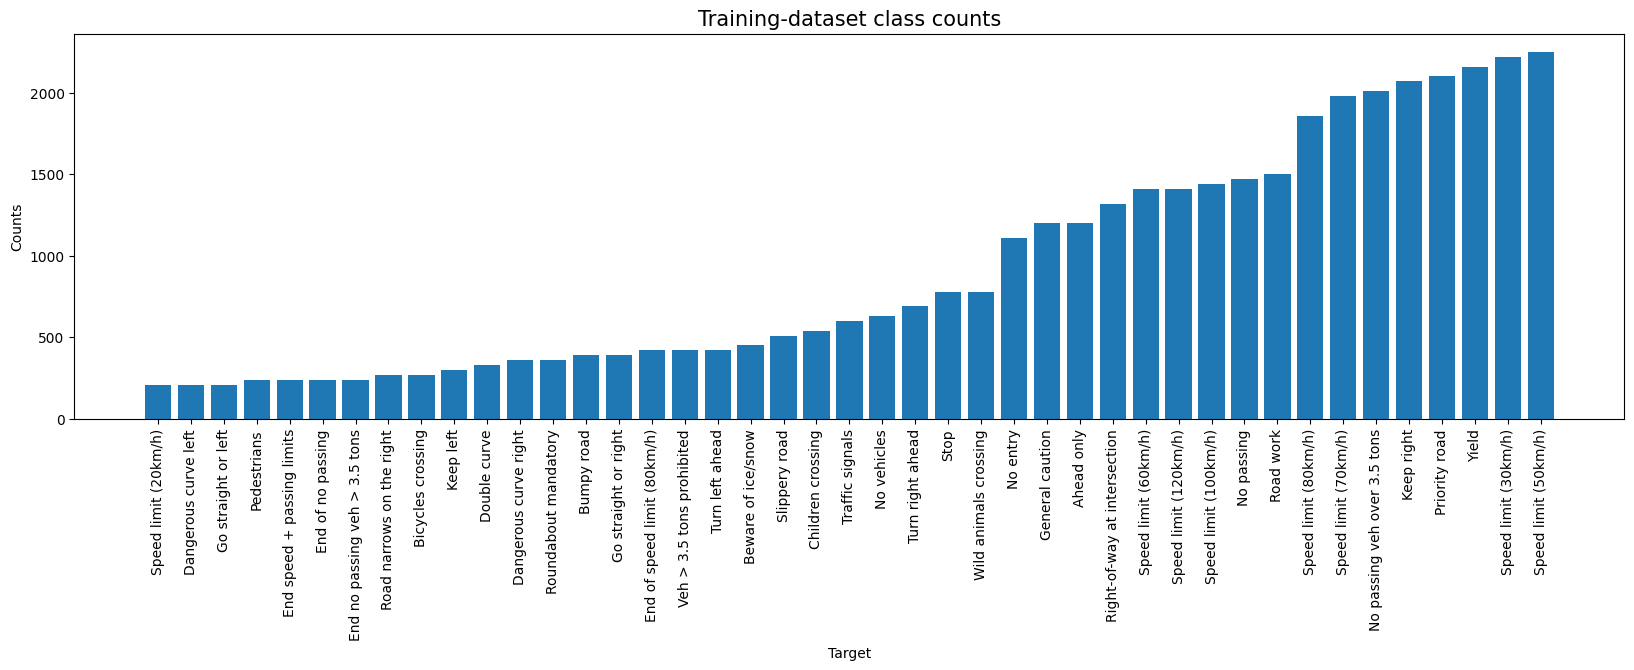

In [39]:
plot_class_counts(train_class_counts, 'Training')

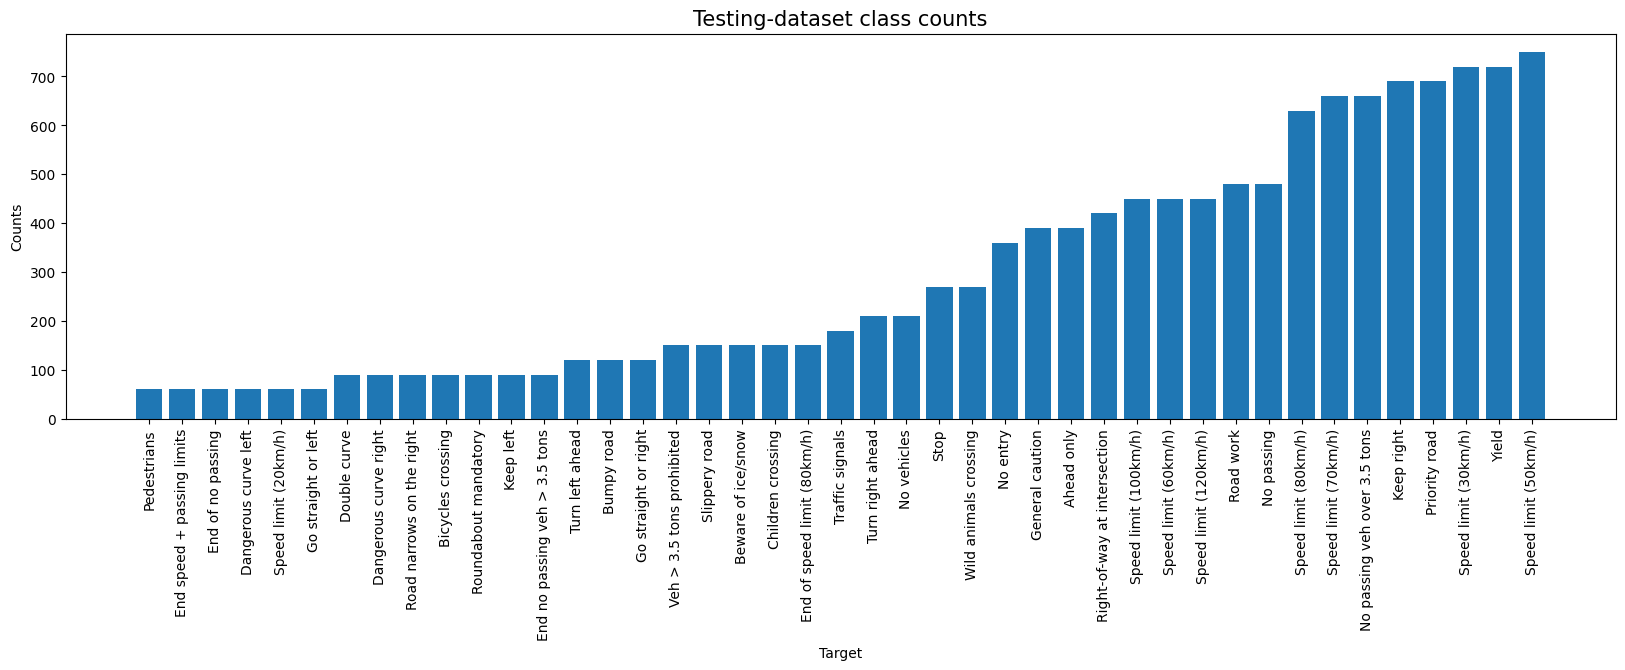

In [40]:
plot_class_counts(test_class_counts, 'Testing')

its clear that we are dealing with imbalanced dataset

# Splitting the Train dataset

In [41]:
x_train, x_val = train_test_split(train_dataset,train_size=0.6, random_state=42, shuffle=True)

In [42]:
sub_train_class_counts = get_class_counts(x_train)
sub_val_class_counts   = get_class_counts(x_val)

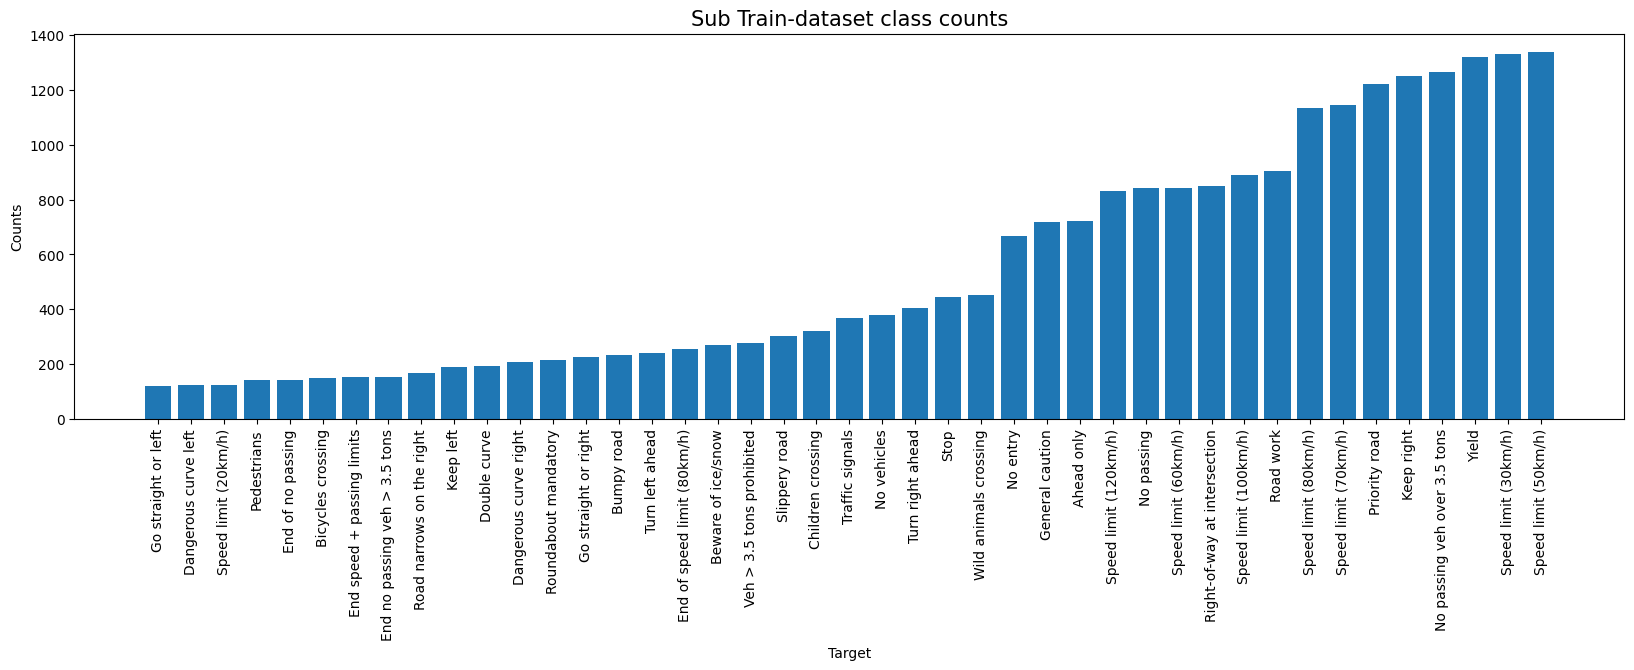

In [43]:
plot_class_counts(sub_train_class_counts, 'Sub Train')

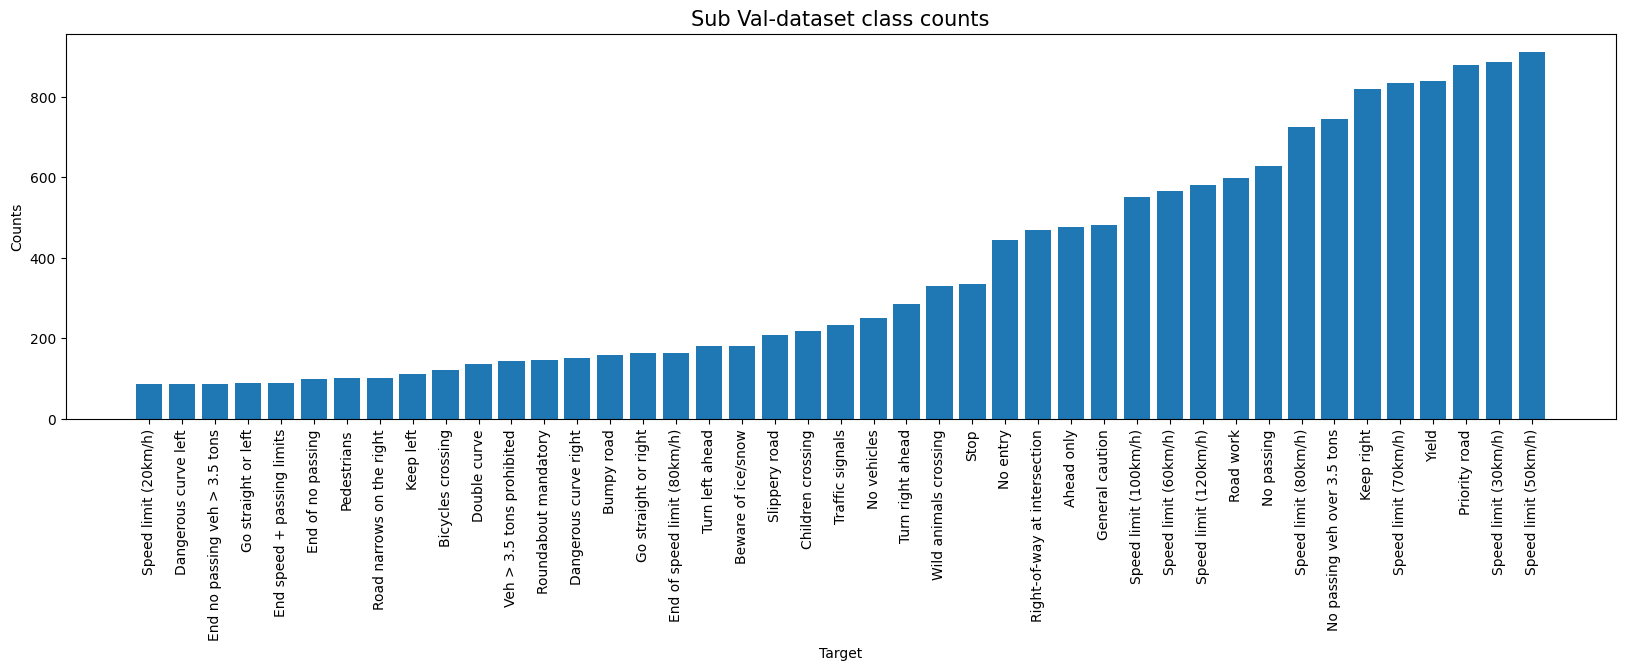

In [44]:
plot_class_counts(sub_val_class_counts, 'Sub Val')

nearly same distribution

# Imbalance handeling

In [45]:
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes= np.unique(x_train['Target']),
                                     y= x_train['Target'])

classes = (np.unique(x_train['Target']))
class_weights_forplot = dict(zip(classes, class_weights))

In [46]:
class_weights = dict(zip(range(43), class_weights))

In [47]:
class_weights

{0: 0.7566985107272669,
 1: 2.0262704565030147,
 2: 3.671765256750429,
 3: 2.3683680660424846,
 4: 1.7043396363109469,
 5: 4.44791075817735,
 6: 2.6302549194991056,
 7: 2.820067130184608,
 8: 3.5757713938288496,
 9: 3.8527677694071407,
 10: 2.137082122093023,
 11: 3.6231326043431387,
 12: 0.7609082381861112,
 13: 4.521429944262925,
 14: 2.4101014240344227,
 15: 2.9100692726373083,
 16: 0.43767441860465117,
 17: 0.8202294201736341,
 18: 0.6489834202322823,
 19: 0.4321429883537235,
 20: 1.439718482252142,
 21: 3.9078073089700998,
 22: 0.44806963411614575,
 23: 0.64288251851447,
 24: 3.2565060908084162,
 25: 0.6058615982899379,
 26: 2.55650945446642,
 27: 1.8115663021715693,
 28: 0.6154027258220629,
 29: 0.6591482207901372,
 30: 4.44791075817735,
 31: 0.41042237303511925,
 32: 0.4085832884658805,
 33: 0.6482144825305852,
 34: 0.47697735244621964,
 35: 0.4824453467864321,
 36: 1.2294225241703685,
 37: 1.486665824064712,
 38: 2.2795542635658914,
 39: 1.3508469710020097,
 40: 1.9822210987529

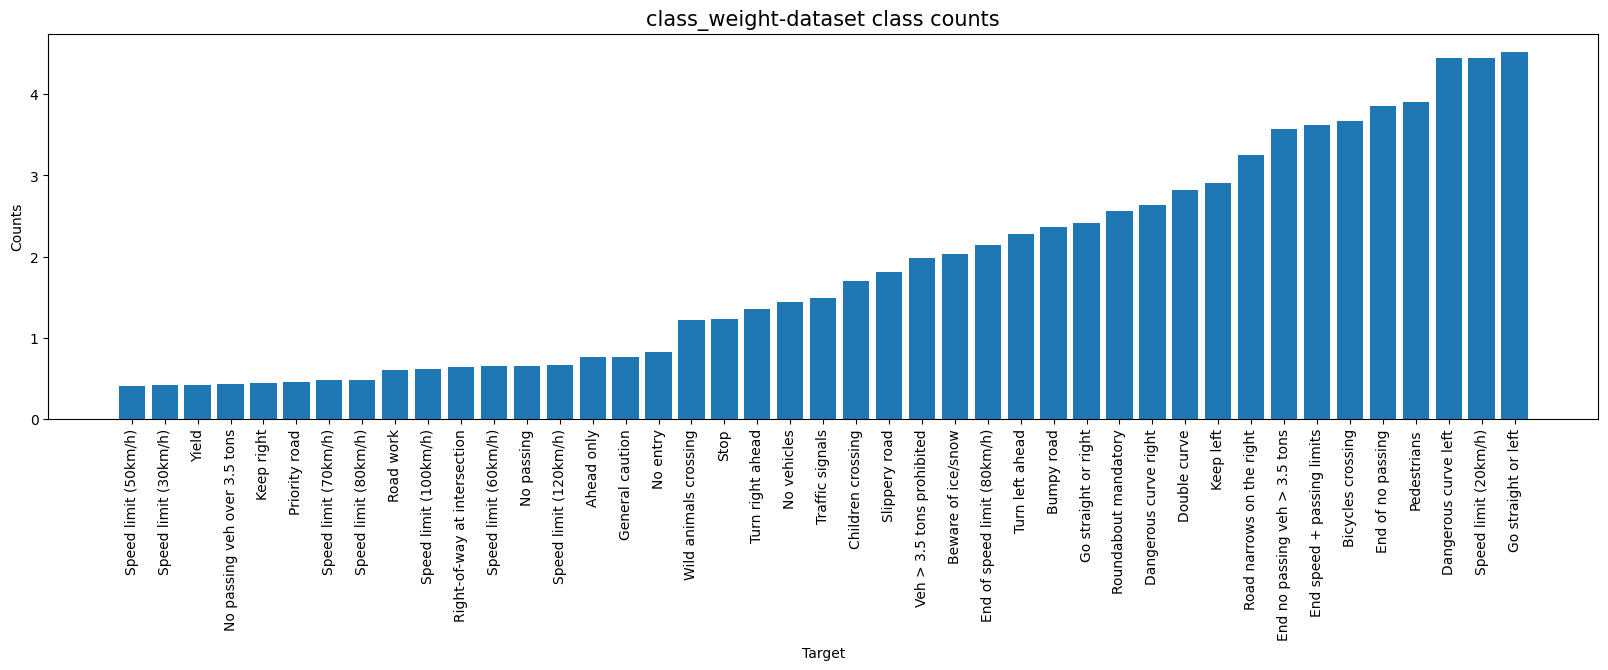

In [48]:
plot_class_counts(class_weights_forplot, 'class_weight')

# Training the models

In [59]:
y_label_col = 'Target'
x_col       = 'Path'
size        = 64
batch_size  = 64

cnn_train_images, train_label   = generate_images(x_train, y_label_col, x_col, size, 64, generator = 0 , use_augmentations = 0, transfer_model=0)
cnn_val_images  , val_label     = generate_images(x_val  , y_label_col, x_col, size, batch_size, generator = 1 , use_augmentations = 0, transfer_model=0)
cnn_test_images , test_label    = generate_images(test_dataset , y_label_col, x_col, size, batch_size, generator = 1 , use_augmentations = 0,transfer_model=0)


trans_train_images, train_label   = generate_images(x_train, y_label_col, x_col, size, 1000, generator = 0 , use_augmentations = 0, transfer_model=1)
trans_val_images  , val_label     = generate_images(x_val  , y_label_col, x_col, size, batch_size, generator = 1 , use_augmentations = 0, transfer_model=1)
trans_test_images , test_label    = generate_images(test_dataset , y_label_col, x_col, size, batch_size, generator = 1 , use_augmentations = 0,transfer_model=1)

Found 23525 validated image filenames belonging to 43 classes.
Found 15684 validated image filenames belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.
Found 23525 validated image filenames belonging to 43 classes.
Found 15684 validated image filenames belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.


### Transfer Learning model training

In [72]:
# the implmentation of the transfer learning model on the train dataset

input_image_size = size
dence1           = 1080
dence2           = 1080
regularizer      = 0.00
drop             = 0.3
drop_conv        = 0.2
trans_model= tf.keras.applications.EfficientNetB0

trans_model = TransL_Model_init(trans_model,
                    input_image_size,
                    dence1          ,
                    dence2          ,
                    regularizer     ,
                    drop            ,
                    drop_conv)

In [73]:
trans_model ,lr_schedule= Model_compile_param(model = trans_model,
                                        initial_learning_rate     = 1e-2,
                                        learning_rate_decay_steps  =24,
                                        learning_rate_decay_rate   =0.95,
                                        Adam_beta_1                =0.9,
                                        Adam_beta_2                =0.999,)

In [52]:
os.mkdir("/content/trans-model_checkpoints")
os.mkdir("/content/cnn-model_checkpoints")

transmodel_csvlogger = tf.keras.callbacks.CSVLogger(
                                            filename='/content/trans-model_checkpoints/training_log.csv',
                                            separator=',',
                                            append=False)
cnnmodel_csvlogger = tf.keras.callbacks.CSVLogger(
                                            filename='/content/trans-model_checkpoints/training_log.csv',
                                            separator=',',
                                            append=False)

In [74]:
history = trans_model.fit(
      trans_train_images                   ,
      validation_data=trans_val_images     ,
      verbose         = True         ,
      epochs          =100            ,
      class_weight    = class_weights,
          callbacks=[
          tf.keras.callbacks.LearningRateScheduler(lr_schedule),
          tf.keras.callbacks.EarlyStopping(
              monitor='val_loss',
              patience=15,#min_delta=0.05,
              restore_best_weights=True),
              transmodel_csvlogger
                        ])

Epoch 1/100
24/24 [==============================] - 41s 1s/step - loss: 3.0057 - accuracy: 0.4139 - f1_m: 0.4137 - val_loss: 3.3956 - val_accuracy: 0.4691 - val_f1_m: 0.4739 - lr: 0.0100
Epoch 2/100
24/24 [==============================] - 24s 970ms/step - loss: 0.9918 - accuracy: 0.6261 - f1_m: 0.6188 - val_loss: 1.1974 - val_accuracy: 0.6264 - val_f1_m: 0.6360 - lr: 0.0095
Epoch 3/100
24/24 [==============================] - 21s 869ms/step - loss: 0.6586 - accuracy: 0.7288 - f1_m: 0.7241 - val_loss: 0.6901 - val_accuracy: 0.7558 - val_f1_m: 0.7514 - lr: 0.0090
Epoch 4/100
24/24 [==============================] - 21s 898ms/step - loss: 0.5000 - accuracy: 0.7776 - f1_m: 0.7763 - val_loss: 0.6110 - val_accuracy: 0.7874 - val_f1_m: 0.7868 - lr: 0.0086
Epoch 5/100
24/24 [==============================] - 35s 1s/step - loss: 0.4053 - accuracy: 0.8179 - f1_m: 0.8167 - val_loss: 0.4891 - val_accuracy: 0.8362 - val_f1_m: 0.8287 - lr: 0.0081
Epoch 6/100
24/24 [==============================] 

plotting the training history 

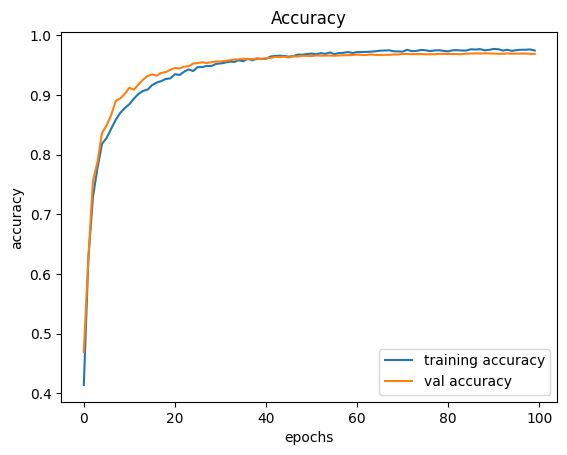

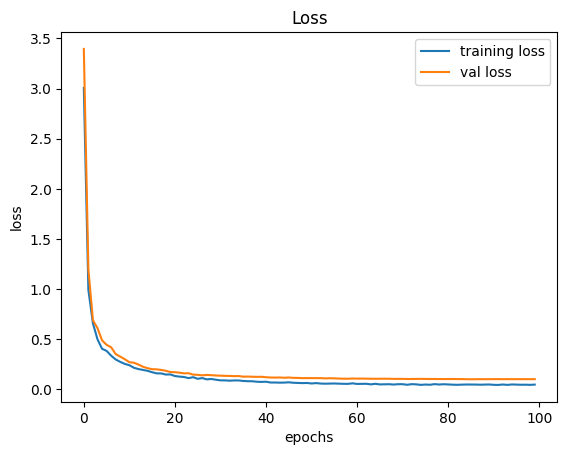

In [75]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [76]:
trans_model.save('/content/drive/MyDrive/traffic_recog/trans_model.keras')

In [77]:
objects = {'recall_m':recall_m,'precision_m':precision_m,'f1_m':f1_m,'KerasLayer':hub.KerasLayer}
trans_model =  keras.models.load_model('/content/drive/MyDrive/traffic_recog/trans_model.keras',compile= True,custom_objects=objects)

### CNN model training

In [54]:
# the implmentation of the CNN model on the train dataset
input_image_size  = 64
dence             = 1080
regularizer       = 0.05
drop_conv         = 0.2 
drop_dense        = 0.3
cnn_model =   CNN_Model_init(
                                input_image_size,
                                dence           ,
                                regularizer     ,
                                drop_conv       ,
                                drop_dense      )

In [58]:
cnn_model ,lr_schedule= Model_compile_param(model = cnn_model,
                                        initial_learning_rate     = 1e-3,
                                        learning_rate_decay_steps  =350,
                                        learning_rate_decay_rate   =0.95,
                                        Adam_beta_1                =0.9,
                                        Adam_beta_2                =0.999,)

In [60]:
history = cnn_model.fit(
                            cnn_train_images                   ,
                            validation_data= cnn_val_images     ,
                            verbose         = True         ,
                            epochs          =100            ,
                            class_weight    = class_weights,
                            callbacks=[
                                        tf.keras.callbacks.LearningRateScheduler(lr_schedule),
                                        tf.keras.callbacks.EarlyStopping(
                                        monitor='val_loss',
                                        patience=5,#min_delta=0.05,
                                        restore_best_weights=True),
                                        cnnmodel_csvlogger
                                      ])

Epoch 1/100
368/368 [==============================] - 35s 84ms/step - loss: 12.7498 - accuracy: 0.7614 - f1_m: 0.7628 - val_loss: 6.3965 - val_accuracy: 0.5485 - val_f1_m: 0.5606 - lr: 9.5000e-04
Epoch 2/100
368/368 [==============================] - 26s 71ms/step - loss: 5.6689 - accuracy: 0.8790 - f1_m: 0.8817 - val_loss: 4.8194 - val_accuracy: 0.8491 - val_f1_m: 0.8456 - lr: 9.0250e-04
Epoch 3/100
368/368 [==============================] - 25s 69ms/step - loss: 5.4122 - accuracy: 0.9134 - f1_m: 0.9159 - val_loss: 5.3587 - val_accuracy: 0.8669 - val_f1_m: 0.8748 - lr: 8.5737e-04
Epoch 4/100
368/368 [==============================] - 25s 69ms/step - loss: 4.8334 - accuracy: 0.9325 - f1_m: 0.9347 - val_loss: 5.8209 - val_accuracy: 0.6536 - val_f1_m: 0.6647 - lr: 8.1451e-04
Epoch 5/100
368/368 [==============================] - 26s 70ms/step - loss: 4.5170 - accuracy: 0.9458 - f1_m: 0.9466 - val_loss: 4.7587 - val_accuracy: 0.9283 - val_f1_m: 0.9316 - lr: 7.7378e-04
Epoch 6/100
368/368

saving the model

In [70]:
cnn_model.save('/content/drive/MyDrive/traffic_recog/cnn_model.keras')

In [71]:
objects = {'recall_m':recall_m,'precision_m':precision_m,'f1_m':f1_m,'KerasLayer':hub.KerasLayer}
cnn_model =  keras.models.load_model('/content/drive/MyDrive/traffic_recog/cnn_model.keras',compile= True,custom_objects=objects)

plotting the training history 

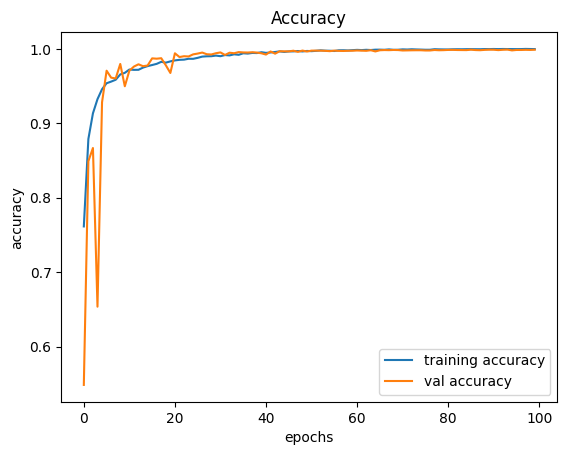

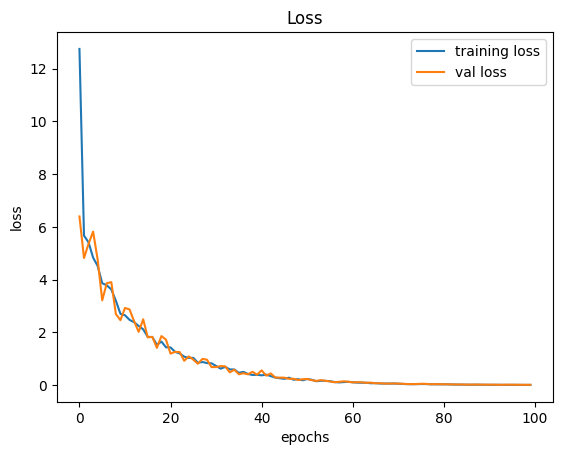

In [65]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

# Evaluating the model

In [118]:
def plot_model_evaluation(model, test_data, n_classes):

    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc  = results[1]
    f1   = results[2]

    print("Test Loss    : {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    print("Test F1 Score: {:.2f}%".format(f1 * 100))

    pred   = model.predict(test_data)
    y_pred = np.argmax(pred, axis= 1)
    cm = confusion_matrix(test_data.labels, y_pred)
    print('----------------------')

    #clr = classification_report(test_data.labels, y_pred, labels=list(test_data.class_indices.keys()), )

    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(n_classes) + 0.5, labels=list(test_data.class_indices.keys()), rotation=90)
    plt.yticks(ticks=np.arange(n_classes) + 0.5, labels=list(test_data.class_indices.keys()), rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    #print("Classification Report:\n----------------------\n", clr)


Test Loss    : 1.27532
Test Accuracy: 73.65%
Test F1 Score: 74.08%
198/198 [==============================] - 9s 46ms/step
----------------------
0.03587772053228131


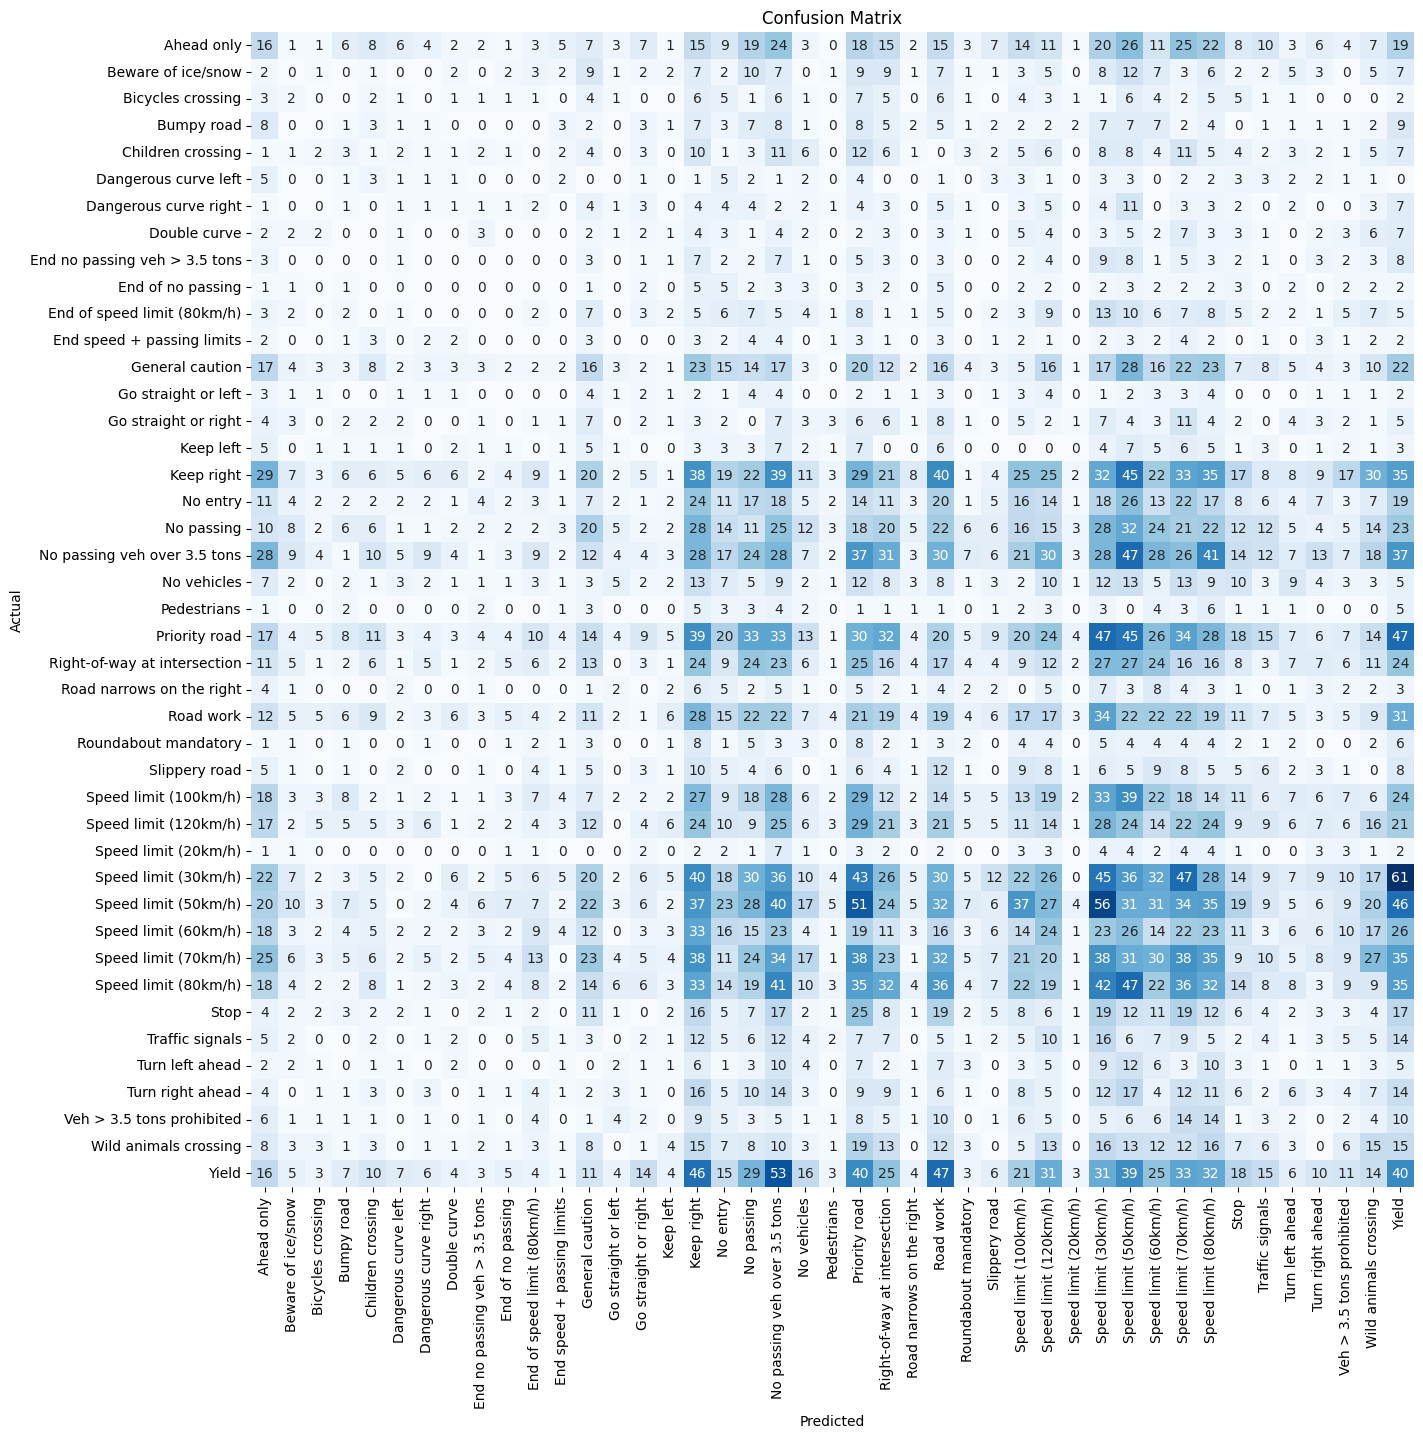

In [116]:
plot_model_evaluation(trans_model, trans_test_images, 43)

Test Loss    : 0.07370
Test Accuracy: 98.30%
Test F1 Score: 98.46%
198/198 [==============================] - 10s 52ms/step
----------------------
0.03733571021658409


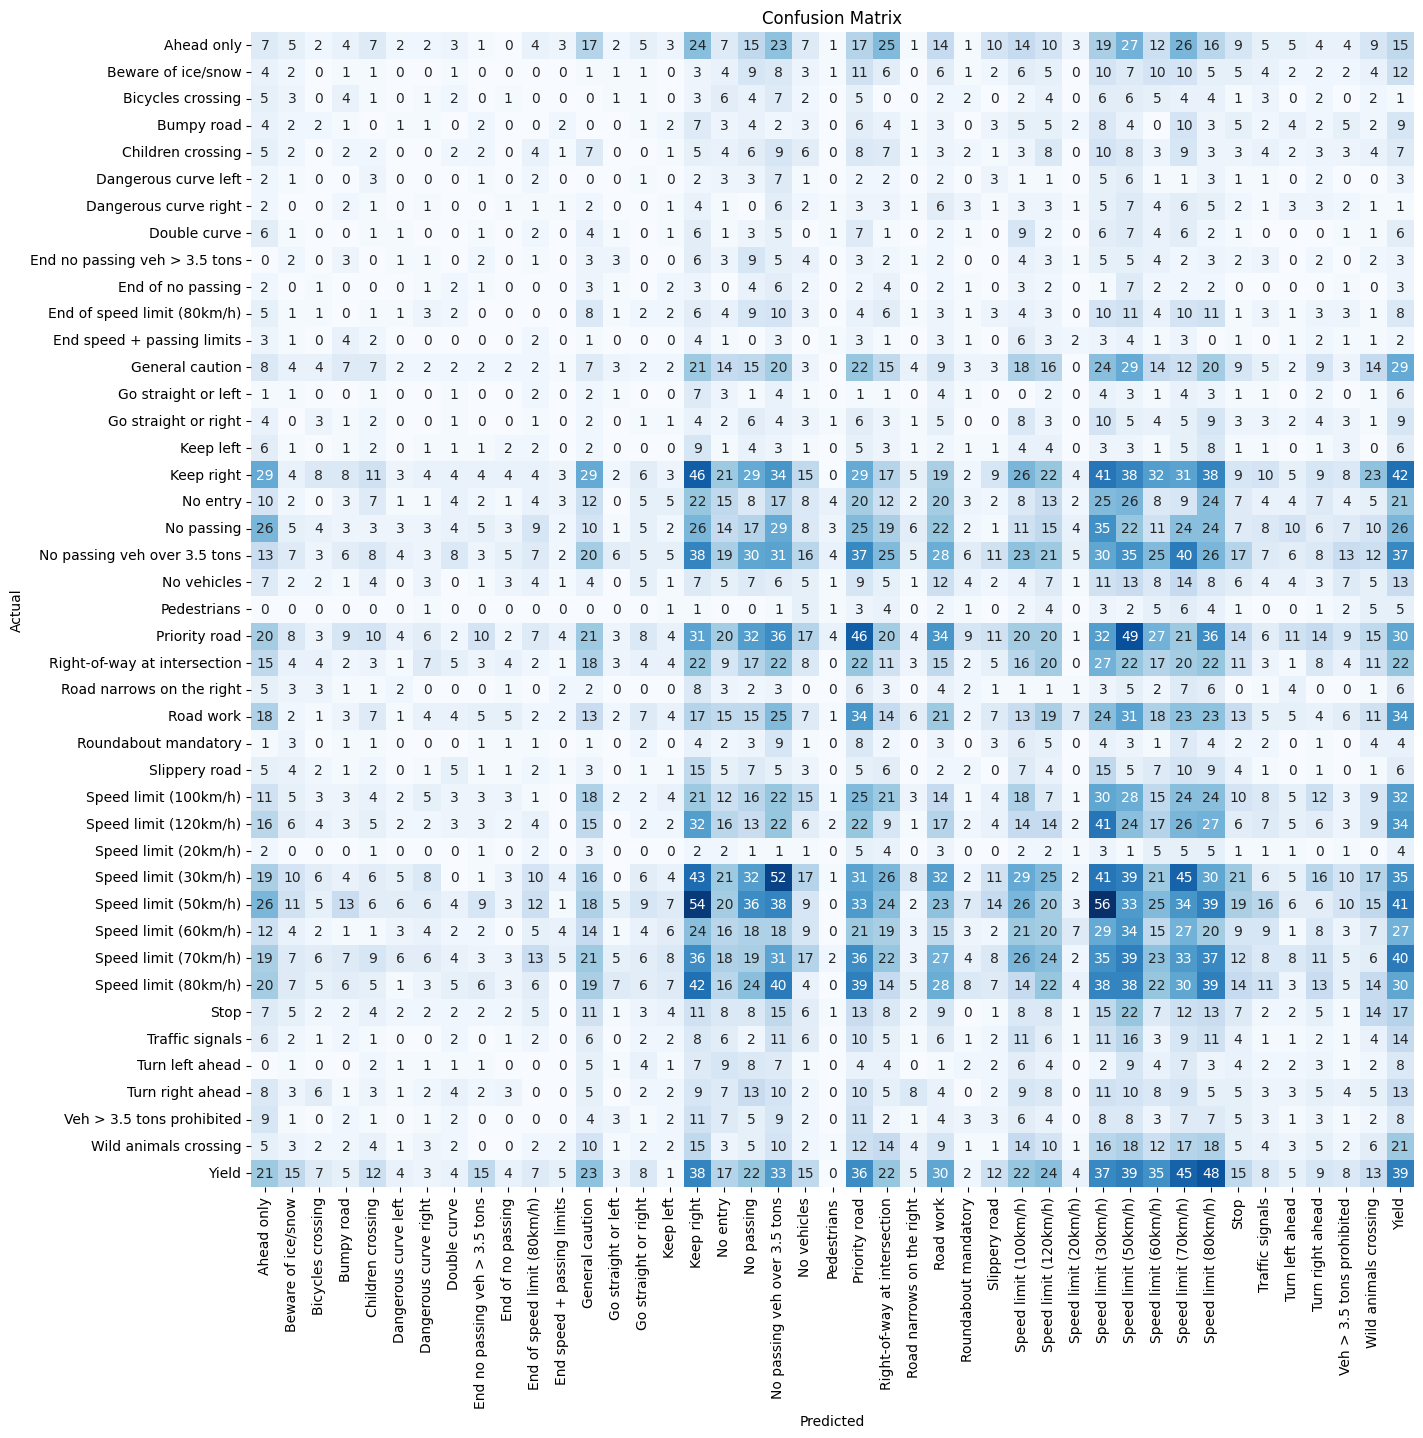

In [117]:
plot_model_evaluation(cnn_model, cnn_test_images, 43)

# Visualizing the CNN model Layers

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in cnn_model.layers[1:]]

visualization_model = tf.keras.models.Model(inputs = cnn_model.input, outputs = successive_outputs)

sign1_files = [os.path.join('/kaggle/working/Training/1', f) for f in train_1_fnames]
sign2_files = [os.path.join('/kaggle/working/Training/2', f) for f in train_2_fnames]

img_path = random.choice(sign1_files + sign2_files)
img = load_img(img_path, target_size=(64, 64))  # this is a PIL image

x   = img_to_array(img)                          
x   = x.reshape((1,) + x.shape)                  

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in cnn_model.layers]


# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )


In [ ]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual     = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(test_images[start_index + i])
plt.show()